<a href="https://colab.research.google.com/github/evpozdniakov/ds_projects/blob/master/hw7/math-ML-2-practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
import random

random.seed(42)

%matplotlib inline

Добавим вспомагательные функции

In [2]:
def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)

    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax


Прочитаем исходные данные:

In [3]:
data = pd.read_csv('https://github.com/evpozdniakov/ds_projects/raw/master/hw7/unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

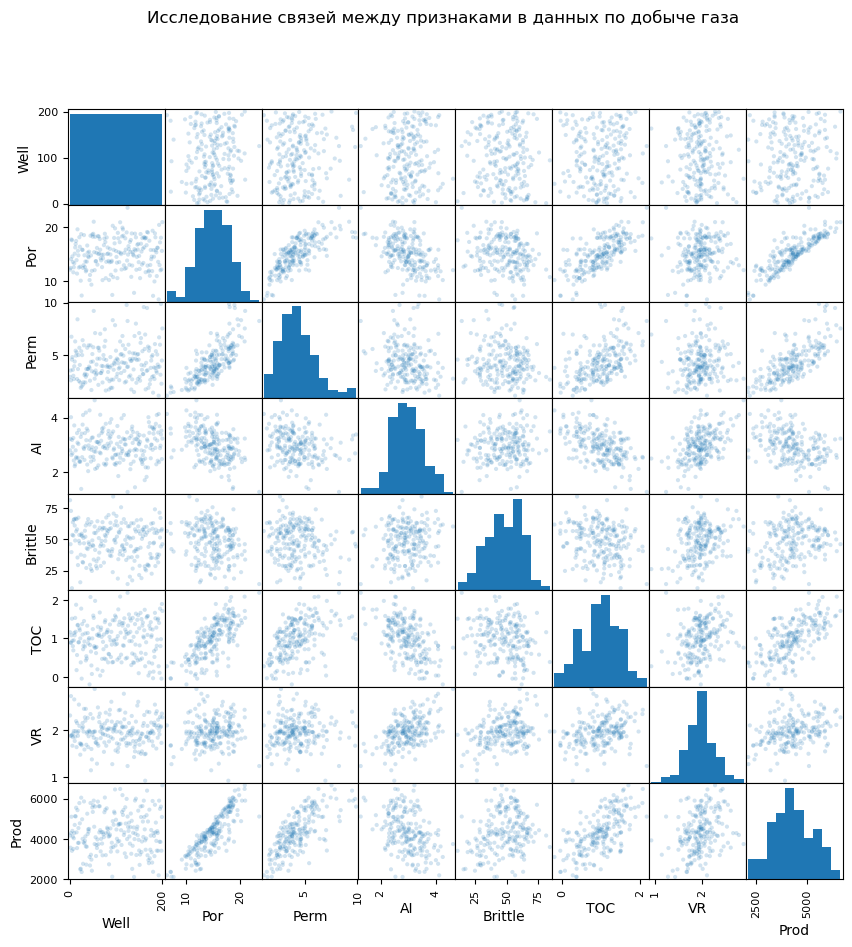

In [4]:
# Построим матрицу точечных диаграмм для наших данных и проанализируем ее.

pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(10, 10), diagonal='hist');

plt.suptitle('Исследование связей между признаками в данных по добыче газа');

#### Вывод

Мы видим, что несколько признаков очень сильно влияют на целевой:

- `Por` — пористость скважины — связь очень сильная, прямая
- `Perm` — проницаемость скважины — связь сильная, прямая
- `TOC` — общий углерод — связь сильная, прямая
- `AI` — аккустический импеданс — связь средняя, обратная
- `VR`- коэф. отражения - связь слабая, прямая
- `Brittle` - коэф. хрупкости - связь слабая, прямая
- `Well` — идентификатор — связь отсутствует

Также мы видим, что между `Perm`, `Por` и `TOC` также существуют сильные прямые связи, и возможно понадобиться удалить какой-то из них, чтобы избежать мультиколлинеарности.

Данные во всех признаках кроме `Well` распределены нормально или логнормально. Последний нужно будет удалить из выборки, поскольку он никак нам не поможет.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Матрица корреляций с целевым признаком:
- ранг: 8
- определитель: 0.0007

Матрица корреляций без целевого признака:
- ранг: 7
- определитель: 0.02


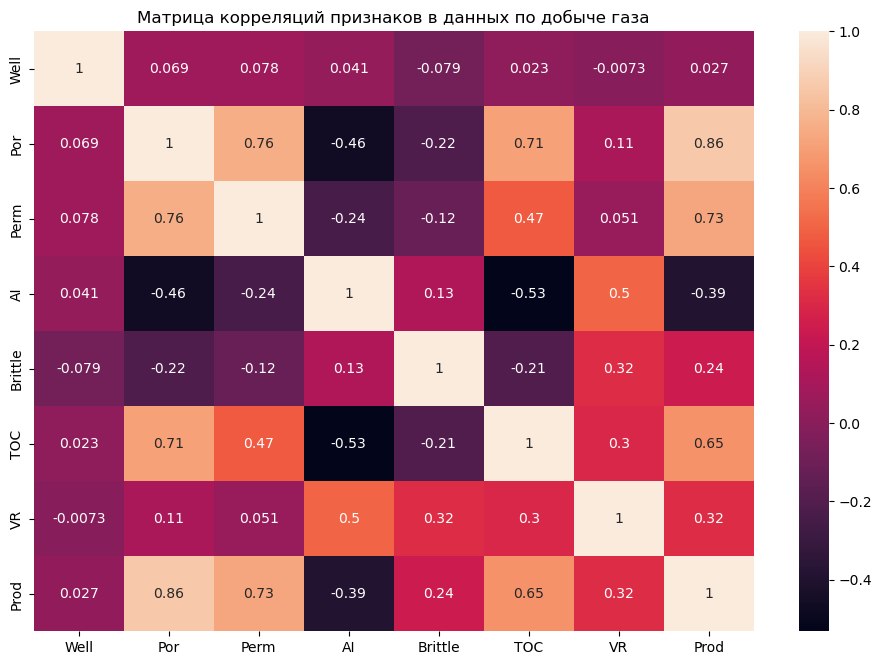

In [5]:
# Посчитаем ранг и определитель матрицы корреляций с целевым признаком
# как требуется в задании
xy_corr = data.corr()
rank = np.linalg.matrix_rank(xy_corr)
det = np.linalg.det(xy_corr)
print('Матрица корреляций с целевым признаком:')
print(f'- ранг: {rank}')
print(f'- определитель: {round(det, 4)}')

# Также посчитаем ранг и определитель матрицы корреляций без целевого призака
# чтобы сравнить с посчитанными выше
x_corr = data.drop(columns=['Prod']).corr()
rank = np.linalg.matrix_rank(x_corr)
det = np.linalg.det(x_corr)
print('\nМатрица корреляций без целевого признака:')
print(f'- ранг: {rank}')
print(f'- определитель: {round(det, 2)}')

# Построим тепловую диаграмму матрицы корреляций с целевым признаком
# как требуется в задании
_fig, ax = figax('corr_heatmap', figsize=(9, 6));
sns.heatmap(xy_corr, ax=ax, annot=True);
ax.set_title('Матрица корреляций признаков в данных по добыче газа');


#### Вывод

Мы видим, что ранг нашей матрицы максимален (соответствует кол-ву признаков). Это значит, что вектора всех признаков (включая целевой) независимы.

Также мы видим, что определитель матрицы близок к нулю. Если определитель близок к нулю **только для данных с целевым признаком**, а без него значительно больше нуля, то это даже хорошо, ведь такая ситуация означала бы, что существует корреляция между каким-то из признаков и целевым, но при этом не существует корреляции между самими признаками.

К сожалению, в нашем случае определитель близок к нулю для матрицы корреляций как с целевым признаком, так и без него. Это означает, что данные, использованные для ее построения **плохо обусловлены**. Также это может говорить о наличии мультиколлинеарности в признаках.

Не смотря на это, мы по-прежнему можем применить метод OLS для вычисления коэфициентов `w` и использовать их для предсказания. Мультиколлинеарность и плохая обусловленность данных скорее всего не окажут существенного влияния на результаты. Но все-таки может возникнуть проблема с интерпретацией полученных коэфициентов.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [6]:
# Напишем функцию, которая будет считать и печатать коэфициенты `w`
# а также возвращять `A`, `X`, `y` и `w`. Она нам пригодится в дальнейшем.
def calc_w(columns_to_drop=[], skip_return=False, skip_display=False):
    columns_to_drop = np.concatenate((['Prod'], columns_to_drop))
    X = data.drop(columns=columns_to_drop)
    A = np.column_stack((np.ones(200), X))
    y = data[['Prod']].values

    # Вычисляем коэфициенты по формуле МНК
    w = np.linalg.inv(A.T@A) @ A.T @ y
    w = w.reshape(A.shape[1],)

    # Выводим коэфициенты на экран
    if skip_display == False:
        col_names = np.concatenate(([''], X.columns))
        for i, (col, col_w) in enumerate(zip(col_names, w)):
            print(f'w{i} = {np.round(col_w)}', end='')

            if col == '':
                print('')
            else:
                print(f' (признак `{col}`)')

    if skip_return == False:
        return A, X, y, w

# Поскольку нам нужно посчитать коэфициенты для всех признаков
# то запускаем функцию без параметра `columns_to_drop`
A, X, y, w = calc_w()

w0 = -1232.0
w1 = 0.0 (признак `Well`)
w2 = 230.0 (признак `Por`)
w3 = 116.0 (признак `Perm`)
w4 = -365.0 (признак `AI`)
w5 = 25.0 (признак `Brittle`)
w6 = -78.0 (признак `TOC`)
w7 = 785.0 (признак `VR`)


#### Вывод

Коэфициент `w1` равен нулю. Это значит, что он никак не влияет на целевой признак. Следовательно, признак `Well` является неинформативным, и его можно смело удалить.

Полученные коэфициенты показывают насколько изменится медианная добыча газа в сутки (в млн. куб. футов) при изменении того или иного признака на единицу.

Например, при увеличении аккустического импеданса (`AI`) на единицу она уменьшится на `365` млн. куб. футов в стки, а при увеличении пористости скважины (`Por`) на `1%` — увеличится на `230`.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [7]:
# Дана реальная добыча газа в сутки для одной скважины
# и ее характеристики в словаре
y_real = 4748.315024
factors = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42,
}

# Из словаря получаем вектор
factor_values = [factors[col] for col in X.columns]

# Добавляем в него единицу для коэфициента `w0`
factor_values = np.insert(factor_values, 0, 1)

# Предсказываем суточную добычу газа для скважины
# (Она есть скалярное произведение векторов `factor_values` и `w`.)
y_pred = factor_values @ w

# Рассчитываем абсолютную ошибку для одной скважины
print(f'MAE для одной скважины: {round(y_real - y_pred, 1)}')

# Считаем суточную добычу для всей матрицы X
y_pred = A @ w

# Рассчитываем две характеристики
print(f'MAE для всех скважин: {round(metrics.mean_absolute_error(y, y_pred), 1)}')

# MAPE
print(f'MAPE для всех скважин: {round(metrics.mean_absolute_percentage_error(y, y_pred) * 100, 1)}%')


MAE для одной скважины: 25.3
MAE для всех скважин: 153.6
MAPE для всех скважин: 3.6%


#### Вывод

Как показывют метрики регрессии, наши коэфициенты позволяют предсказать добычу газа довольно точно.

`MAE` — средняя абсолютная ошибка — у нас равна `153.6` млн. куб. футов в день. Это значит что в среднем наш прогноз отличается от реальности на эту цифру в меньшую или большую сторону. (Значение данной метрики смогут оценить специалисты по добыче газа. Людям же далеким от этой области такая метрика не скажет практически ни о чем.)

`MAPE` — средняя абсолютная ошибка в процентах — у нас равна `3.6%`. Это значит что наш прогноз отличается в среднем на `3.6%` в ту или иную сторону от реальной величины. Хорошей считается модель, способная предсказывать результат с `MAPE < 5%`. (Данная метрика хороша тем, что будет понятна большинству людей.)

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [8]:
print('Коэфициенты посчитанные на данных с мультиколлинеарностью')
calc_w(skip_return=True)

print('\nКоэфициенты посчитанные после устранения мультиколлинеарности')
calc_w(columns_to_drop=['Por'], skip_return=True)

Коэфициенты посчитанные на данных с мультиколлинеарностью
w0 = -1232.0
w1 = 0.0 (признак `Well`)
w2 = 230.0 (признак `Por`)
w3 = 116.0 (признак `Perm`)
w4 = -365.0 (признак `AI`)
w5 = 25.0 (признак `Brittle`)
w6 = -78.0 (признак `TOC`)
w7 = 785.0 (признак `VR`)

Коэфициенты посчитанные после устранения мультиколлинеарности
w0 = 1561.0
w1 = 0.0 (признак `Well`)
w2 = 347.0 (признак `Perm`)
w3 = -884.0 (признак `AI`)
w4 = 16.0 (признак `Brittle`)
w5 = 19.0 (признак `TOC`)
w6 = 1544.0 (признак `VR`)


#### Вывод

У нас имеется один признак, коэфициент `w` которого противоречит коэфициенту его корреляции с целевым признаком. Это — `TOC`. Его коэфициент отрицателен (равен `-78.0`), хотя на матрице корреляций мы видим, что данный признак имеет сильную, прямую корреляцию с целевым признаком (равен `0.65`).

Такая странность, по всей видимости, связана с наличием мультиколлинеарности в данных. После устранения мультиколлинеарности противоречие исчезает.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [9]:
# Две пары факторов имеют сильную (> 0.7) корреляцию:
# - Por+Perm
# - Por+TOC
# Можно было бы удалить только Por, но поскольку среди всех факторов
# он имеет самое большое влияние на целевой признак, то мы его оставим
# и удалим два други признака
# А также удалим признак `Well` поскольку он не оказывает влияния на результат
print('Коэфициенты после удаления признаков `Perm`, `TOC`, `Well`:')
A, X, y, w = calc_w(columns_to_drop=['Perm', 'TOC', 'Well'])

# Считаем суточную добычу газа для всей матрицы X
y_pred = A @ w

# Рассчитываем наши метрики
print('\nМетрики:')
print(f'MAE для всех скважин: {round(metrics.mean_absolute_error(y, y_pred), 1)}')
print(f'MAPE для всех скважин: {round(metrics.mean_absolute_percentage_error(y, y_pred) * 100, 1)}%')


Коэфициенты после удаления признаков `Perm`, `TOC`, `Well`:
w0 = -1835.0
w1 = 293.0 (признак `Por`)
w2 = -200.0 (признак `AI`)
w3 = 28.0 (признак `Brittle`)
w4 = 517.0 (признак `VR`)

Метрики:
MAE для всех скважин: 171.4
MAPE для всех скважин: 4.0%


#### Вывод

Наши новые коэфициенты немного отличаются от предыдущих. Некоторые немного выросли (`Por` с `230` до `293` и `Brittle` с `25` до `28`), другие значительно уменьшились (`AI` с `-365` до `-200` и `VR` с `785` до `517`). Но важно то, что все они соответствуют по знаку коэфициентам корреляции с целевым признаком.

Наши новые коэфициенты говорят следующее. При увеличении пористости скважины (`Por`) на `1%`, медианная суточная добыча газа увеличится на `293` млн. куб. футов. При увеличении витринита (`VR`) на `1%`, она вырастет еще больше — на `517`  млн. куб. футов. А при увеличении хрупкости скважины (`Brittle`) на тот же `1%` она увеличится лишь на `28` млн. куб. футов.

Наши новые метрики немного хуже предыдущих: `MAE` выросла с `153.6` до `171.4`, а `MAPE` — с `3.6` до `4.0`

Метрика `MAE` нам говорит, что в среднем наш прогноз отличается от реальности на `171.4` млн. куб. футов в сутки в меньшую или большую сторону.

Метрика `MAPE` нам говорит, что наш прогноз отличается в среднем на `4%` в ту или иную сторону от реальной величины, что по-прежнему неплохо, ведь хорошей считается модель, способная предсказывать результат с `MAPE < 5%`.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [10]:
# Создаем и обучаем модель линейной регрессии
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

# Выводим на экран коэфициенты
print('Коэфициенты посчитанные моделью LinearRegression (без округления):')
lr_w = np.concatenate((lr_model.intercept_, lr_model.coef_[0]))
for (i, wi) in enumerate(lr_w):
    print(f'w{i}: {wi}')

# Считаем и выводим на экран метрики
print('\nМетрики полученной модели:')
y_pred = lr_model.predict(X)
print(f'MAE: {round(metrics.mean_absolute_error(y, y_pred), 1)}')
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y, y_pred) * 100, 1)}%')

# Еще раз выводим коэфициенты, посчитанные ранее методом OLS
print('\nКоэфициенты посчитанные методом OLS (без округления):')
for (i, wi) in enumerate(w):
    print(f'w{i}: {wi}')

Коэфициенты посчитанные моделью LinearRegression (без округления):
w0: -1835.44646069403
w1: 293.0362456539231
w2: -200.030912058179
w3: 27.640982091076275
w4: 517.4027259694722

Метрики полученной модели:
MAE: 171.4
MAPE: 4.0%

Коэфициенты посчитанные методом OLS (без округления):
w0: -1835.4464606940057
w1: 293.03624565392505
w2: -200.0309120581889
w3: 27.64098209107584
w4: 517.4027259694662


#### Вывод

Модель линейнорй регресси `LinearRegression` библиотеки `sklearn` нашла такие же коэфициенты (совпадают до 10 знака после запятой), какие нашли мы сами при помощи метода OLS и после устранения мультиколлинеарности. Видимо класс `LinearRegression` тоже использует метод OLS для поиска коэфициентов.

Поскольку коэфициенты совпадают, то и метрики тоже совпадают.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [11]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import optuna


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [12]:
# Используем StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерируем полиноминальные признаки 3 порядка
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Выводим на экран новое кол-во признаков
print(f'Кол-во признаков после добавления полиноминальных: {X_poly.shape[1]}')

# Создаем объект модели LinearRegression
lr_model = linear_model.LinearRegression()

# Обучаем ее с помощью кросс валидации
cv_metrics = cross_validate(
    estimator=lr_model,
    X=X_poly,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
)

# Вычисляем и выводим на экран метрики
print('\nMAPE линейной регрессии (OLS) на полиноминальных признаках:')
mape_train = round(cv_metrics['train_score'].mean() * -100, 2)
print(f'- на тренировочных фолдах: {mape_train}%')
mape_test = round(cv_metrics['test_score'].mean() * -100, 2)
print(f'- на тестовых фолдах: {mape_test}%')

# lr_model.fit(X_train, y_train)

# print('w0: {}'.format(lr_model.intercept_))
# print('w1: {}'.format(lr_model.coef_))

Кол-во признаков после добавления полиноминальных: 34

MAPE линейной регрессии (OLS) на полиноминальных признаках:
- на тренировочных фолдах: 1.77%
- на тестовых фолдах: 2.68%


#### Вывод

После добавления полиноминальных признаков `3` степени мы смогли значительно улучшить метрику `MAPE`. Вместе с тем мы получили переобученную модель, поскольку разница в метриках на тренировочных и тестовых фолдах составляет `2.68 - 1.77 = 0.91 %`.

Нам следует применить регуляризацию, чтобы приблизить тестовую метрику к тренировочной.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [13]:
# создаем функцию для поиска оптимальных гиперпараметров
def optuna_rf_lasso(trial):
    # задаем пространство поиска
    alpha = trial.suggest_float('alpha', 0.1, 30, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 10000, log=True)

    # создаем модель
    lasso = linear_model.Lasso(alpha=alpha, max_iter=max_iter)

    # обучаем с помощью кросс-валидации
    score = cross_val_score(lasso, X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    score = score.mean() * -100

    return score

# создаем процесс обучения и запускаем его
study = optuna.create_study(study_name='Optuna: Lasso, metric: MAPE', direction='minimize')
study.optimize(optuna_rf_lasso, n_trials=25)

print('Наилучшие значения гиперпараметров')
print(study.best_params)

# Создаем объект модели Lasso с найденными гиперпараметрами
alpha = study.best_params['alpha']
max_iter = study.best_params['max_iter']
lasso = linear_model.Lasso(alpha=alpha, max_iter=max_iter)

# Обучаем с помощью кросс валидации
cv_metrics = cross_validate(
    estimator=lasso,
    X=X_poly,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
)

# Вычисляем и выводим на экран метрики
print('\nMAPE линейной регресси с регуляризацией `L₁` на полиноминальных признаках:')
mape_train = round(cv_metrics['train_score'].mean() * -100, 2)
print(f'- на тренировочных фолдах: {mape_train}%')
mape_test = round(cv_metrics['test_score'].mean() * -100, 2)
print(f'- на тестовых фолдах: {mape_test}%')


[I 2023-05-07 20:28:44,976] A new study created in memory with name: Optuna: Lasso, metric: MAPE
/Users/ev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.714e+04, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/ev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+04, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
[I 2023-05-07 20:28:45,682] Trial 0 finished with value: 2.574915230013385 and parameters: {'alpha': 0.3765448291424901, 'max_iter': 538}. Best is trial 0 with value: 2.574915230013385.
[

Наилучшие значения гиперпараметров
{'alpha': 5.07510373313661, 'max_iter': 938}

MAPE линейной регресси с регуляризацией `L₁` на полиноминальных признаках:
- на тренировочных фолдах: 1.83%
- на тестовых фолдах: 2.28%


#### Вывод

Применив регуляризацию `L₁` нам удалось улучшить приблизить тренировочную и тестовую метрики друг к другу. Теперь разница между ними составляет `2.28 - 1.83 = 0.45 %` по сравнению с `0.91 %` полученными методом OLS.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [14]:
# создаем функцию для поиска оптимальных гиперпараметров
def optuna_rf_ridge(trial):
    # задаем пространство поиска
    alpha = trial.suggest_float('alpha', 0.1, 30, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 10000, log=True)

    # создаем модель
    ridge = linear_model.Ridge(alpha=alpha, max_iter=max_iter)

    # обучаем с помощью кросс-валидации
    score = cross_val_score(ridge, X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    score = score.mean() * -100

    return score

# создаем процесс обучения и запускаем его
study = optuna.create_study(study_name='Optuna: Ridge, metric: MAPE', direction='minimize')
study.optimize(optuna_rf_ridge, n_trials=25)

print('Наилучшие значения гиперпараметров')
print(study.best_params)

# Создаем объект модели Ridge с найденными гиперпараметрами
alpha = study.best_params['alpha']
max_iter = study.best_params['max_iter']
ridge = linear_model.Ridge(alpha=alpha, max_iter=max_iter)

# Обучаем с помощью кросс валидации
cv_metrics = cross_validate(
    estimator=ridge,
    X=X_poly,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
)

# Вычисляем и выводим на экран метрики
print('\nMAPE линейной регресси с регуляризацией `L₂` на полиноминальных признаках:')
mape_train = round(cv_metrics['train_score'].mean() * -100, 2)
print(f'- на тренировочных фолдах: {mape_train}%')
mape_test = round(cv_metrics['test_score'].mean() * -100, 2)
print(f'- на тестовых фолдах: {mape_test}%')


[I 2023-05-07 20:28:46,710] A new study created in memory with name: Optuna: Ridge, metric: MAPE
[I 2023-05-07 20:28:46,719] Trial 0 finished with value: 5.07559706961731 and parameters: {'alpha': 24.378996158910315, 'max_iter': 273}. Best is trial 0 with value: 5.07559706961731.
[I 2023-05-07 20:28:46,727] Trial 1 finished with value: 2.6727885467208 and parameters: {'alpha': 0.10372507619093023, 'max_iter': 719}. Best is trial 1 with value: 2.6727885467208.
[I 2023-05-07 20:28:46,733] Trial 2 finished with value: 2.672113956741098 and parameters: {'alpha': 0.15302705256718793, 'max_iter': 6392}. Best is trial 2 with value: 2.672113956741098.
[I 2023-05-07 20:28:46,738] Trial 3 finished with value: 2.687988747449265 and parameters: {'alpha': 0.5826547242002454, 'max_iter': 426}. Best is trial 2 with value: 2.672113956741098.
[I 2023-05-07 20:28:46,744] Trial 4 finished with value: 2.8086078625662148 and parameters: {'alpha': 1.878259443341391, 'max_iter': 126}. Best is trial 2 with va

Наилучшие значения гиперпараметров
{'alpha': 0.1624079905870448, 'max_iter': 5142}

MAPE линейной регресси с регуляризацией `L₂` на полиноминальных признаках:
- на тренировочных фолдах: 1.77%
- на тестовых фолдах: 2.67%


#### Вывод

С помощью регуляризации `L₂` нам не удалось улучшить метрики. Они остались такими же, какие мы получи, посчитав модель метдом OLS после добавления полиноминальных признаков (`1.77%` и `2.68%` соответственно)

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [15]:
# создаем функцию для поиска оптимальных гиперпараметров
def optuna_rf_elastic_net(trial):
    # задаем пространство поиска
    alpha = trial.suggest_float('alpha', 0.1, 30, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1.0, step=0.1)
    max_iter = trial.suggest_int('max_iter', 100, 10000, log=True)

    # создаем модель
    elastic_net = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)

    # обучаем с помощью кросс-валидации
    score = cross_val_score(elastic_net, X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    score = score.mean() * -100

    return score

# создаем процесс обучения и запускаем его
study = optuna.create_study(study_name='Optuna: ElasticNet, metric: MAPE', direction='minimize')
study.optimize(optuna_rf_elastic_net, n_trials=35)

print('Наилучшие значения гиперпараметров')
print(study.best_params)

# Создаем объект модели ElasticNet с найденными гиперпараметрами
alpha = study.best_params['alpha']
l1_ratio = study.best_params['l1_ratio']
max_iter = study.best_params['max_iter']
elastic_net = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)

# Обучаем с помощью кросс валидации
cv_metrics = cross_validate(
    estimator=elastic_net,
    X=X_poly,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
)

# Вычисляем и выводим на экран метрики
print('\nMAPE линейной регресси с регуляризацией `Elastic-Net` на полиноминальных признаках:')
mape_train = round(cv_metrics['train_score'].mean() * -100, 2)
print(f'- на тренировочных фолдах: {mape_train}%')
mape_test = round(cv_metrics['test_score'].mean() * -100, 2)
print(f'- на тестовых фолдах: {mape_test}%')


[I 2023-05-07 20:28:46,931] A new study created in memory with name: Optuna: ElasticNet, metric: MAPE
[I 2023-05-07 20:28:46,937] Trial 0 finished with value: 8.085536101855464 and parameters: {'alpha': 1.7017905593546572, 'l1_ratio': 0.6000000000000001, 'max_iter': 1102}. Best is trial 0 with value: 8.085536101855464.
[I 2023-05-07 20:28:46,943] Trial 1 finished with value: 3.7975612218547368 and parameters: {'alpha': 0.6197434834353035, 'l1_ratio': 0.9, 'max_iter': 1453}. Best is trial 1 with value: 3.7975612218547368.
[I 2023-05-07 20:28:46,948] Trial 2 finished with value: 8.47656670271523 and parameters: {'alpha': 7.659741730787042, 'l1_ratio': 0.9, 'max_iter': 775}. Best is trial 1 with value: 3.7975612218547368.
[I 2023-05-07 20:28:46,952] Trial 3 finished with value: 7.618065915436027 and parameters: {'alpha': 1.8170365709395775, 'l1_ratio': 0.7000000000000001, 'max_iter': 3761}. Best is trial 1 with value: 3.7975612218547368.
[I 2023-05-07 20:28:46,960] Trial 4 finished with v

Наилучшие значения гиперпараметров
{'alpha': 4.568273221524139, 'l1_ratio': 1.0, 'max_iter': 8400}

MAPE линейной регресси с регуляризацией `Elastic-Net` на полиноминальных признаках:
- на тренировочных фолдах: 1.82%
- на тестовых фолдах: 2.28%


#### Вывод

Мы не смогли улучшить результат с помощью комбинации регуляризаций `L₁` и `L₂`, поскольку метрки, найденные метдом `Elastic-Net`, почти такие же, какие мы уже находили с помощью модели `Lasso` (`1.83%` и `2.28%`). Об этом свидетельствует и найденное значение гиперпараметра `l1_ratio` — оно равно единице, а это значит, что модель использовала только регуляризацию `L₁`.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [17]:

lr = linear_model.LinearRegression()

# Определим метрики на тренировочных и тестовых фолдах
# для модели LinearRegression — они нужны будут для отчета
cv_metrics = cross_validate(
    estimator=lr,
    X=X,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
)
lr_mape_train = round(cv_metrics['train_score'].mean() * -100, 2)
lr_mape_test = round(cv_metrics['test_score'].mean() * -100, 2)

# Создаем отчет
pd.DataFrame({
    'model_name': ['LinearRegression', 'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet'],
    'hyperparams': ['', '', 'alpha=5.0, max_iter=3323', 'alpha=0.2, max_iter=205',
        'alpha=3.7, max_iter=100'],
    'is_poly': [False, True, True, True, True],
    'mape_train': [lr_mape_train, 1.77, 1.84, 1.77, 1.81],
    'mape_test': [lr_mape_test, 2.68, 2.28, 2.67, 2.28],
})

pd.DataFrame(
    columns=[
        'Модель',
        'Гиперпараметры',
        'Полиноминальные признаки',
        'MAPE на тренировочных данных, %',
        'MAPE на тестовых данных, %',
    ],
    data=[
        ['Linear regression', '', 'Нет', lr_mape_train, lr_mape_test],
        ['Linear regression', '', 'Да', 1.77, 2.68],
        ['Lasso', 'alpha=5.4, max_iter=2268', 'Да', 1.83, 2.28],
        ['Ridge', 'alpha=0.16, max_iter=1881', 'Да', 1.77, 2.67],
        ['ElasticNet', 'alpha=4.06, l1_ratio=1.0, max_iter=427', 'Да', 1.82, 2.28],
    ],
)


,Модель,Гиперпараметры,Полиноминальные признаки,"MAPE на тренировочных данных, %","MAPE на тестовых данных, %"
0,Linear regression,,Нет,4.02,4.23
1,Linear regression,,Да,1.77,2.68
2,Lasso,"alpha=5.4, max_iter=2268",Да,1.83,2.28
3,Ridge,"alpha=0.16, max_iter=1881",Да,1.77,2.67
4,ElasticNet,"alpha=4.06, l1_ratio=1.0, max_iter=427",Да,1.82,2.28


Согласно проведенному исследованию, лучшей предсказательной способностью обладает модель линейной регрессии с L₁-регуляризацией — модель `Lasso`. Есть две другие модели, показавшие лучший результат на тренировочных данных, но при этом худший на тестовых, что может быть следствием их переобучения.